In [5]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

torch.manual_seed(7)
datadir = "\\Users\\morar\\Documents\\Work_AI\\Pneumonia Recognizer\\chest_xray"



In [6]:
!dir "Work_AI\Pneumonia Recognizer"

 Volume in drive C has no label.
 Volume Serial Number is 02D5-6D6D

 Directory of C:\Users\morar\Documents\Work_AI\Pneumonia Recognizer

14/06/2024  15:54    <DIR>          .
14/06/2024  15:54    <DIR>          ..
14/06/2024  13:48    <DIR>          .ipynb_checkpoints
14/06/2024  13:29    <DIR>          chest_xray
14/06/2024  15:37           345,006 main.ipynb
14/06/2024  17:22     4,330,293,843 X_cache.tudor
14/06/2024  17:20                 0 y_cache.tudor
               3 File(s)  4,330,638,849 bytes
               4 Dir(s)  431,475,707,904 bytes free


In [7]:
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import os
import cv2

class PneumoniaDataset(Dataset):
    
    def __init__(self, datadir, transform=None):
        self.datadir = datadir
        self.transform = transform
        self.normal = os.listdir(datadir + "/NORMAL")
        self.pneumonia = os.listdir(datadir + "/PNEUMONIA")
        
    def __len__(self):
        return len(self.normal) + len(self.pneumonia)
    
    def __getitem__(self, idx):
        if idx < len(self.normal):
            path = self.datadir + "/NORMAL/" + self.normal[idx]
            y = 0
        else:
            path = self.datadir + "/PNEUMONIA/" + self.pneumonia[idx - len(self.normal)]
            y = 1
            
        image = cv2.imread(path)
        image = cv2.resize(image, (256, 256))
        if transform:
            image = self.transform(image)
            
        return image, y
    
    
transform = (transforms.Compose([transforms.ToTensor()]))

trainset = PneumoniaDataset(datadir + "/train", transform=transform)
testset = PneumoniaDataset(datadir + "/test", transform=transform)
valset = PneumoniaDataset(datadir + "/val", transform=transform)

batch_size = 16
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=True)
valloader = DataLoader(valset, batch_size=batch_size, shuffle=True)

print(len(trainloader))
print(len(testloader))

327
39


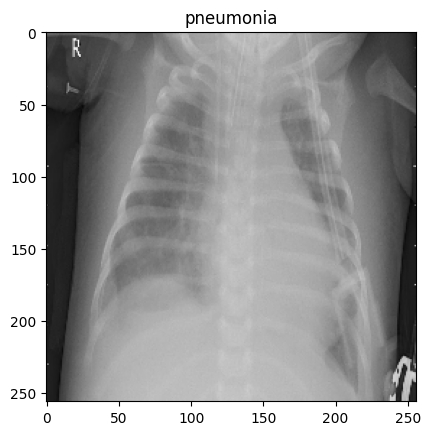

In [8]:
import matplotlib.pyplot as plt

image, label = trainset[5000]
classes = {0: "normal", 1: "pneumonia"}
plt.imshow(image.permute(1, 2, 0))
plt.title(classes[label])
plt.show()

In [9]:
device = torch.device("cuda");

In [10]:
from torch import nn, optim

class PneumoniaClassifier(nn.Module):
    
    def __init__(self):
        super(PneumoniaClassifier, self).__init__()
        self.cnn = nn.Sequential(                                   #Input image is 3x256x256
            nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),   #image is 16x128x128
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(2, stride=2, padding=0),                   #image is 16x64x64
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),  #image is 32x32x32
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2, stride=2, padding=0),                   #image is 32x16x16
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  #image is 64x8x8
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, stride=2, padding=0),                   #image is 64x4x4
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1), #image is 128x2x2
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Flatten(),
            nn.Dropout(0.3),
            nn.Linear(128 * 2 * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 2),
        )
    
    def forward(self, x):
        return self.cnn(x)
        
model = PneumoniaClassifier().to(device);
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"The model has {total_params} trainable parameters")

The model has 130882 trainable parameters


### Training & Evaluation

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
model.train()

for epoch in range(5):
    print(f"epoch: {epoch}")
    running_loss = 0.0

    for i, data in enumerate(trainloader):
        images, labels = data
        
        images.to(device);
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:    # print every 100 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 100:.3f}')
            running_loss = 0.0

print('Finished Training')

epoch: 0


RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

In [ ]:
correct = 0
total = 0
model.eval()

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the {total} test images: {100 * correct // total} %')